# Demo for

## Learning to Compare: Relation Network for Few-Shot Learning

### Sung et al, arXiv:1711.06025, 2017

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

### As a toy problem, we have 8 classes, each class is represented by a 'base' image (3x3 binary image), and the samples in one specific class are generated by its 'base' added some random noise

In [2]:
x1 = np.array([1,1,0,
               1,1,0,
               0,0,0])

x2 = np.array([1,1,1,
               1,0,1,
               1,1,1])

x3 = np.array([0,1,0,
               1,1,1,
               0,1,0])

x4 = np.array([0,0,0,
               0,1,1,
               0,1,1])

x5 = np.array([1,0,0,
               1,0,0,
               1,0,0])

x6 = np.array([0,0,0,
               1,1,1,
               0,0,0])

x7 = np.array([0,0,1,
               0,0,1,
               0,0,1])

x8 = np.array([1,0,1,
               0,1,0,
               1,0,1])

x = np.vstack([x1,x2,x3,x4,x5,x6,x7,x8])

### See how they look like

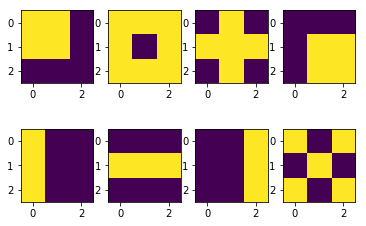

In [3]:
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x[i].reshape((3,3)))

### We have 8x8=64 pairs, of which 8 pairs are of the same label (matched pairs) and 56 pairs are of different labels (mismatched pairs)

In [4]:
same_class = []
diff_class = []

for i in range(len(x)):
    for j in range(len(x)):
        if i == j:
            same_class.append(np.hstack([x[i],x[j]]))
        else:
            diff_class.append(np.hstack([x[i],x[j]]))
            
same_class = np.array(same_class)
diff_class = np.array(diff_class)

### Matched pairs have similarity 1 and the mismatched pair have similarity 0

In [5]:
data = np.vstack([same_class, diff_class])
label = np.vstack([np.ones((len(same_class),1)),np.zeros((len(diff_class),1))])

### Build a regression model

In [6]:
x1 = tf.placeholder(tf.float32, [None, 9]) # sample image placeholder
x2 = tf.placeholder(tf.float32, [None, 9]) # query image placeholder
y = tf.placeholder(tf.float32, [None, 1]) # label placeholder (note: label is either 0 or 1, but it is a regression problem)

### Embedding module: map the image from 9D (3x3 binary image) to 1D

In [7]:
w0 = tf.Variable(tf.truncated_normal([9,1]))
b0 = tf.Variable(tf.truncated_normal([1]))

In [8]:
h1 = tf.nn.elu(tf.nn.xw_plus_b(x1,w0,b0))
h2 = tf.nn.elu(tf.nn.xw_plus_b(x2,w0,b0))

### Concatenation: each pair is now a 2D vector

In [9]:
h = tf.concat([h1,h2],axis=1)

### Relation module: map the concatenated feature (2D) to a similarity score (1D)

### Here relation module is realised by a two-layer NN, 2D --> 3D --> 1D

In [10]:
w1 = tf.Variable(tf.truncated_normal([2,3]))
b1 = tf.Variable(tf.truncated_normal([3]))

In [11]:
h3 = tf.nn.elu(tf.nn.xw_plus_b(h,w1,b1))

In [12]:
w2 = tf.Variable(tf.truncated_normal([3,1]))
b2 = tf.Variable(tf.truncated_normal([1]))

In [13]:
o = tf.nn.xw_plus_b(h3,w2,b2)
o_normalised = tf.nn.sigmoid(o)

### MSE loss

In [14]:
loss = tf.reduce_mean(tf.squared_difference(o_normalised,y))

### Optimiser

In [15]:
opt = tf.train.AdamOptimizer(0.1)
train = opt.minimize(loss)

In [16]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

### Embedding of image before learning (each point is a (sample query) pair, where x-axis value is sample's embedding and y-axis value is query's embedding)

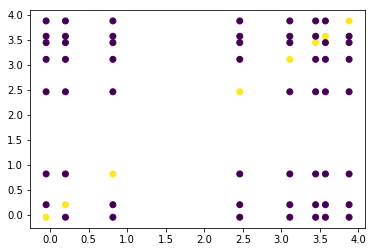

In [17]:
h_value = h.eval(feed_dict={x1:data[:,0:9], x2:data[:,9:]})
plt.scatter(h_value[:,0], h_value[:,1], c=label.flatten())

### Learning

In [18]:
for I in range(1000):
    _, loss_value = sess.run([train, loss], 
                             feed_dict={x1:data[:,0:9]+np.random.randn(*np.shape(data[:,0:9]))*0.05,
                                        x2:data[:,9:]+np.random.randn(*np.shape(data[:,9:]))*0.05,
                                        y:label})
    if I % 100 == 0:
        print(loss_value)

0.46713
0.100168
0.0566801
0.0356856
0.0147445
0.00301538
0.0489105
0.0115872
0.0102867
0.0193709


### Embedding of image after learning (we should observe better discriminative)

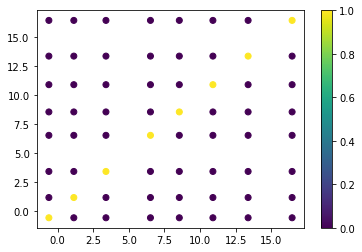

In [19]:
h_value = h.eval(feed_dict={x1:data[:,0:9], x2:data[:,9:]})
plt.scatter(h_value[:,0], h_value[:,1], c=label.flatten())
plt.colorbar()

### Output of relation module (we should observe that the points along diagonal have values closing to one, because the input for relation module is 2D vector (1D sample, 1D query) [a,b], where a~=b leads to matched pair )

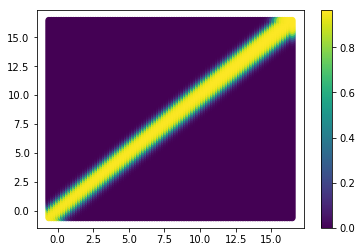

In [20]:
x_sample = np.linspace(np.min(h_value), np.max(h_value), 100)
y_sample = np.linspace(np.min(h_value), np.max(h_value), 100)
samples = np.array([[i,j] for i in x_sample for j in y_sample])

scores = tf.nn.sigmoid(tf.nn.xw_plus_b(tf.nn.elu(tf.nn.xw_plus_b(samples.astype(np.float32),w1,b1)),w2,b2)).eval()

plt.scatter(samples[:,0], samples[:,1], c=scores.flatten())
plt.colorbar()